# **Submission Akhir: Menyelesaikan Permasalahan Institusi Pendidikan**

*   Name: Rasyid Alfiansyah
*   Email: rasyidalfiansyh@gmail.com
*   Dicoding ID: rasyid_alfiansyah







# Persiapan

## Menyiapkan library yang dibutuhkan

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from google.colab import files

## Menyiapkan data yang akan diguankan

In [2]:
url = (
    'https://raw.githubusercontent.com/dicodingacademy/dicoding_dataset/refs/heads/' \
    'main/students_performance/data.csv'
)

df = pd.read_csv(url, sep=';')
df.head()

,Marital_status,Application_mode,Application_order,Course,Daytime_evening_attendance,Previous_qualification,Previous_qualification_grade,Nacionality,Mothers_qualification,Fathers_qualification,...,Curricular_units_2nd_sem_credited,Curricular_units_2nd_sem_enrolled,Curricular_units_2nd_sem_evaluations,Curricular_units_2nd_sem_approved,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Unemployment_rate,Inflation_rate,GDP,Status
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


# Data Understanding

In [3]:
print(df.info())
print(df.describe())
print(df.select_dtypes(include='object').nunique())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Marital_status                                4424 non-null   int64  
 1   Application_mode                              4424 non-null   int64  
 2   Application_order                             4424 non-null   int64  
 3   Course                                        4424 non-null   int64  
 4   Daytime_evening_attendance                    4424 non-null   int64  
 5   Previous_qualification                        4424 non-null   int64  
 6   Previous_qualification_grade                  4424 non-null   float64
 7   Nacionality                                   4424 non-null   int64  
 8   Mothers_qualification                         4424 non-null   int64  
 9   Fathers_qualification                         4424 non-null   i

# Data Preparation / Preprocessing

In [4]:
df.dropna(inplace=True)
print("After dropna, shape:", df.shape)

df.drop_duplicates(inplace=True)
print("After drop_duplicates, shape:", df.shape)

# Hapus kolom selain graduate dan dropout
df = df[df['Status'].isin(['Graduate', 'Dropout'])]

# Save cleaned data for dashboard
clean_file = 'data_cleaned.csv'
df.to_csv(clean_file, index=False)

After dropna, shape: (4424, 37)
After drop_duplicates, shape: (4424, 37)


# Exploratory Data Analysis

## Correlation Heatmap

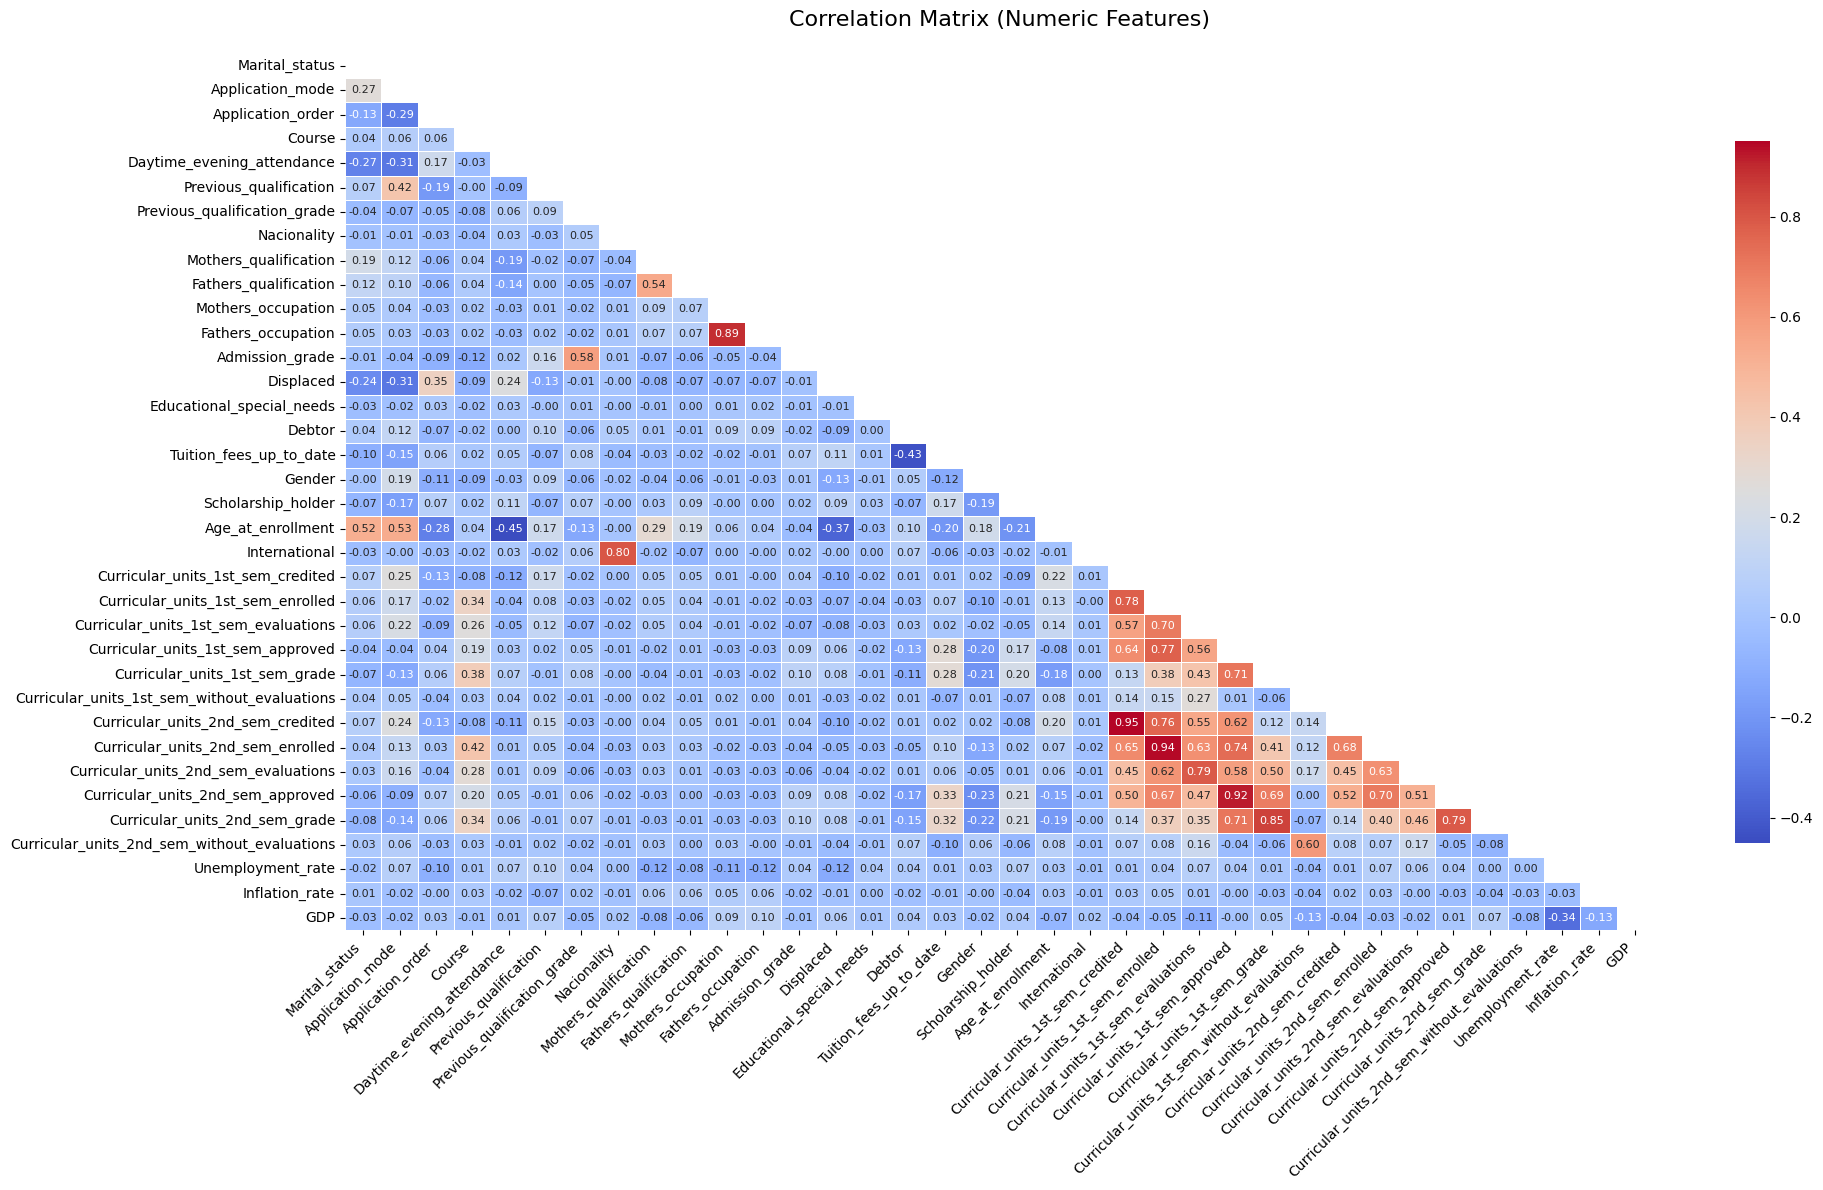

In [5]:
plt.figure(figsize=(20,12))
num_cols = df.select_dtypes(include=[np.number]).columns
corr = df[num_cols].corr().round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    linewidths=0.5,
    annot_kws={'size':8},
    cbar_kws={'shrink':0.8}
)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Correlation Matrix (Numeric Features)', pad=20, size=16)
plt.tight_layout()
plt.show()

## Distribution of Numerical Features

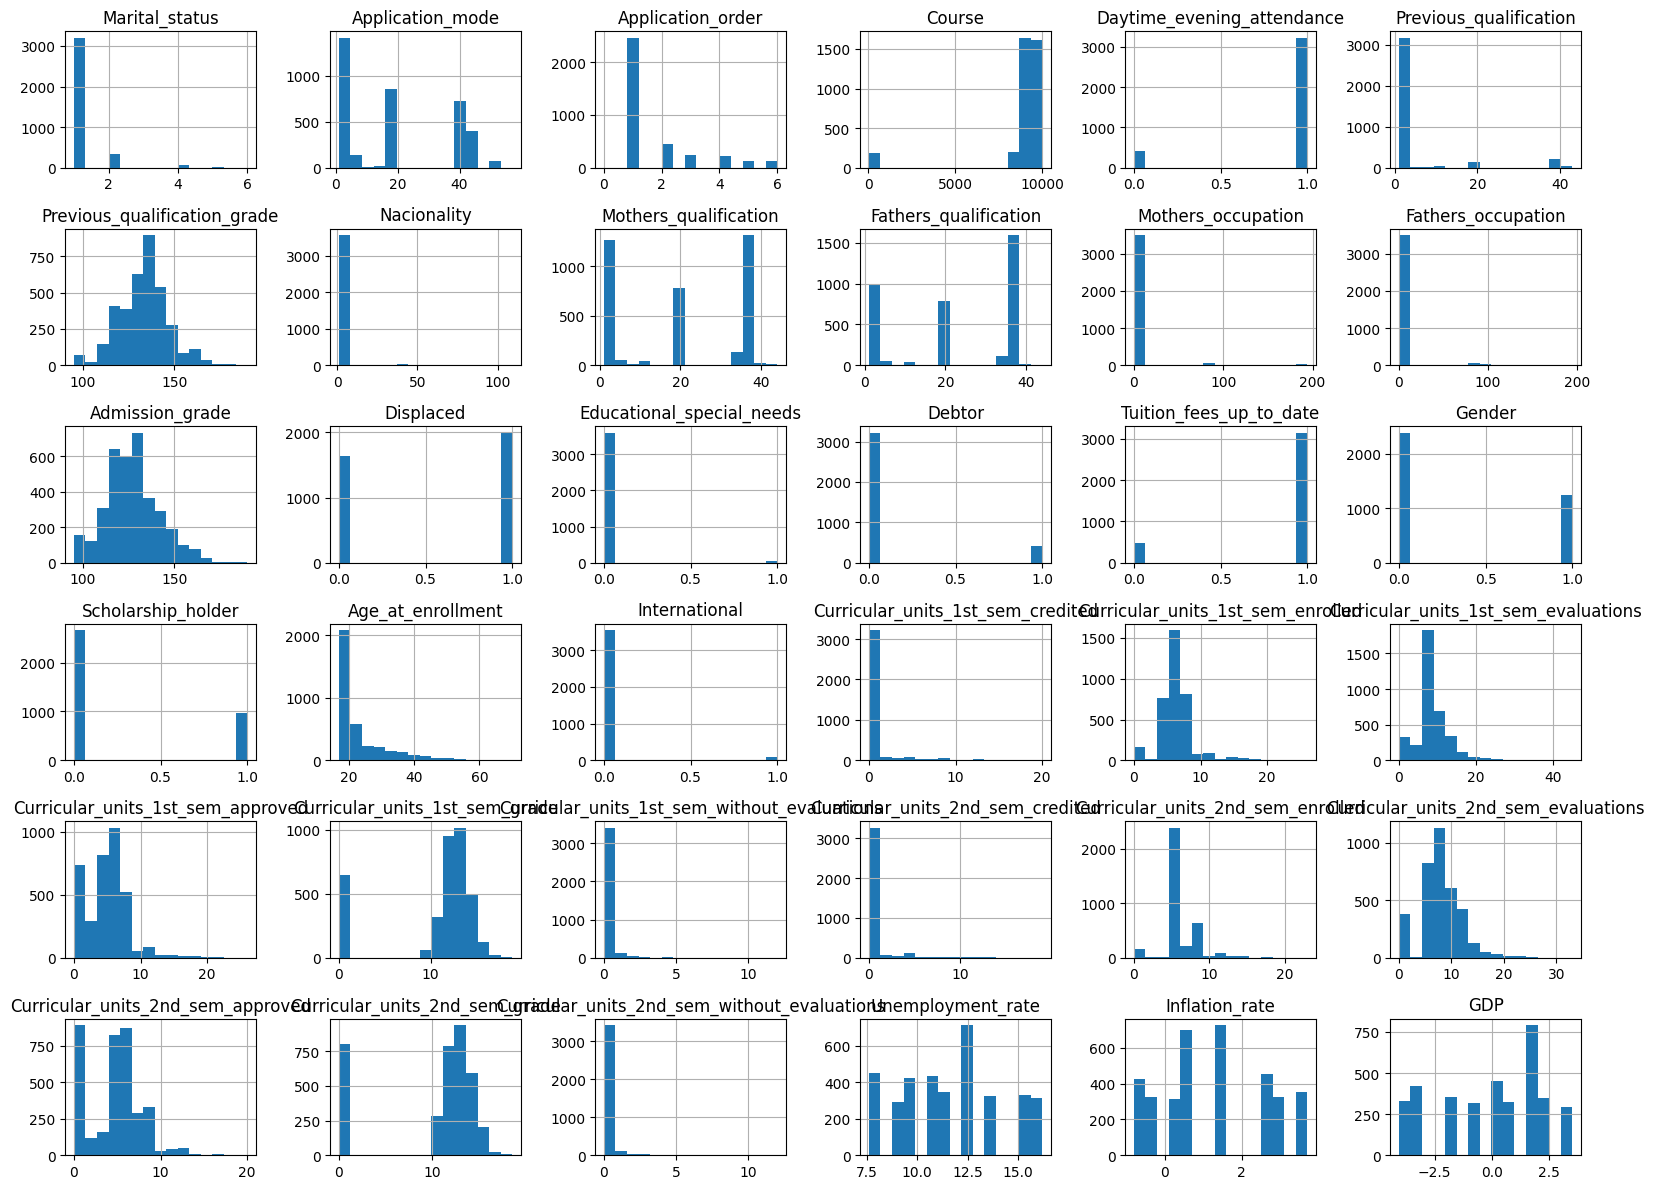

In [6]:
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols].hist(bins=15, figsize=(16,12))
plt.tight_layout()
plt.show()

## Status Balance

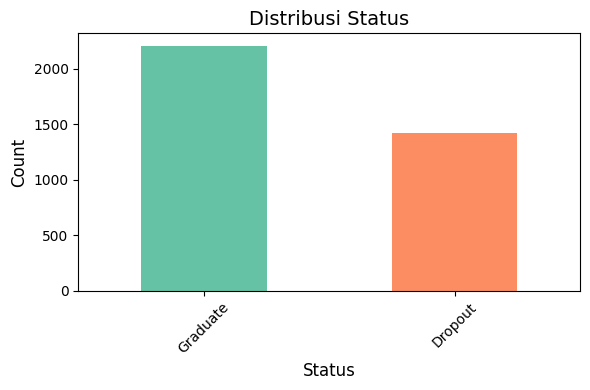

In [7]:
# Hitung frekuensi
counts = df['Status'].value_counts()

# Buat palette sebanyak kategori
colors = sns.color_palette("Set2", counts.size)

# Plot pakai pandas
ax = counts.plot.bar(figsize=(6,4), color=colors)

# Styling
ax.set_title('Distribusi Status', size=14)
ax.set_xlabel('Status', size=12)
ax.set_ylabel('Count', size=12)
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Data Transformation for Modeling

## Make Copy

In [8]:
mod_df = df.copy()

## Encode Target

In [9]:
X = mod_df.drop('Status', axis=1)
y = mod_df['Status']

le_status = LabelEncoder()
y_enc = le_status.fit_transform(y)

## Encode Categorical

In [10]:
X_encoded = X.copy()
for col in X_encoded.select_dtypes(include='object').columns:
    X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col])

## Scale Numerical

In [11]:
num_cols = X_encoded.select_dtypes(include=np.number).columns
X_encoded[num_cols] = MinMaxScaler().fit_transform(X_encoded[num_cols])

## Train/Test Split

In [12]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_enc, stratify=y_enc, test_size=0.2, random_state=42)

# Modeling

In [13]:
models = {
    'Logistic': LogisticRegression(class_weight='balanced', max_iter=10000, random_state=42),
    'SVM': SVC(class_weight='balanced', max_iter=10000, probability=True, random_state=42),
    'DecisionTree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
    'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'KNN': KNeighborsClassifier(),
    'NaiveBayes': GaussianNB()
}

metrics = {}

for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    preds = mdl.predict(X_test)

    metrics[name] = {
        'Accuracy': accuracy_score(y_test, preds),
        'Precision': precision_score(y_test, preds, pos_label=1, average='binary'),
        'Recall': recall_score(y_test, preds, pos_label=1, average='binary'),
        'F1-score': f1_score(y_test, preds, pos_label=1, average='binary')
    }

metrics_df = pd.DataFrame(metrics).T.round(3)
print(metrics_df)

                  Accuracy  Precision  Recall  F1-score
Logistic             0.905      0.906   0.941     0.923
SVM                  0.916      0.908   0.959     0.933
DecisionTree         0.854      0.878   0.882     0.880
RandomForest         0.908      0.888   0.971     0.928
GradientBoosting     0.912      0.895   0.968     0.930
KNN                  0.832      0.817   0.932     0.871
NaiveBayes           0.829      0.841   0.887     0.863


In [14]:
# Ambil model yang sudah ter-fit dari loop sebelumnya
best = models['SVM']

# Evaluation


=== Training ===
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      1137
           1       0.92      0.95      0.93      1767

    accuracy                           0.92      2904
   macro avg       0.92      0.91      0.91      2904
weighted avg       0.92      0.92      0.92      2904



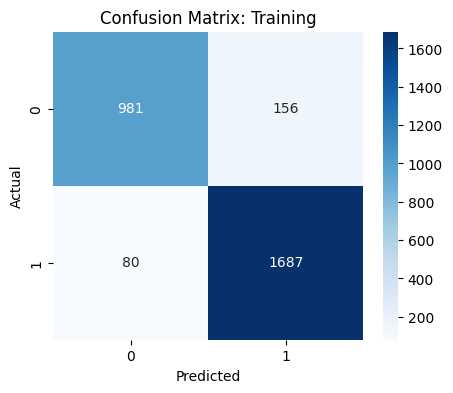


=== Testing ===
              precision    recall  f1-score   support

           0       0.93      0.85      0.89       284
           1       0.91      0.96      0.93       442

    accuracy                           0.92       726
   macro avg       0.92      0.90      0.91       726
weighted avg       0.92      0.92      0.92       726



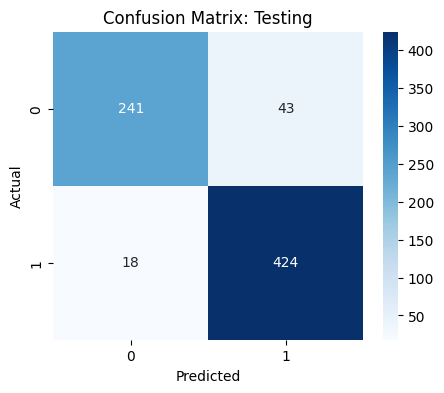

In [15]:
def eval_report(y_true, y_pred, label):
    """
    Cetak classification report dan confusion matrix untuk sebuah label.
    """
    print(f"\n=== {label} ===")
    # Jika kamu punya LabelEncoder bernama `le_status`,
    # bisa pakai `target_names=le_status.classes_` agar nama kelas tampil.
    print(classification_report(y_true, y_pred))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {label}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

train_pred = best.predict(X_train)
test_pred  = best.predict(X_test)

eval_report(y_train, train_pred, 'Training')
eval_report(y_test,  test_pred,  'Testing')

## Analisis Fitur yang Berpengaruh


--- Analisis Fitur Paling Berpengaruh dengan Permutation Importance (Model SVM) ---

Top Fitur Berdasarkan Permutation Importance (Model SVM):
                                         Feature  Importance_Mean  \
30             Curricular_units_2nd_sem_approved     1.400826e-01   
16                       Tuition_fees_up_to_date     6.528926e-02   
31                Curricular_units_2nd_sem_grade     4.352617e-02   
24             Curricular_units_1st_sem_approved     2.561983e-02   
18                            Scholarship_holder     1.625344e-02   
25                Curricular_units_1st_sem_grade     1.432507e-02   
29          Curricular_units_2nd_sem_evaluations     1.377410e-02   
1                               Application_mode     1.363636e-02   
33                             Unemployment_rate     1.322314e-02   
3                                         Course     1.239669e-02   
17                                        Gender     1.198347e-02   
15                          

<ipython-input-16-b0046e7fc4e9>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance_Mean', y='Feature', data=feature_importance_perm.head(15), palette='viridis')


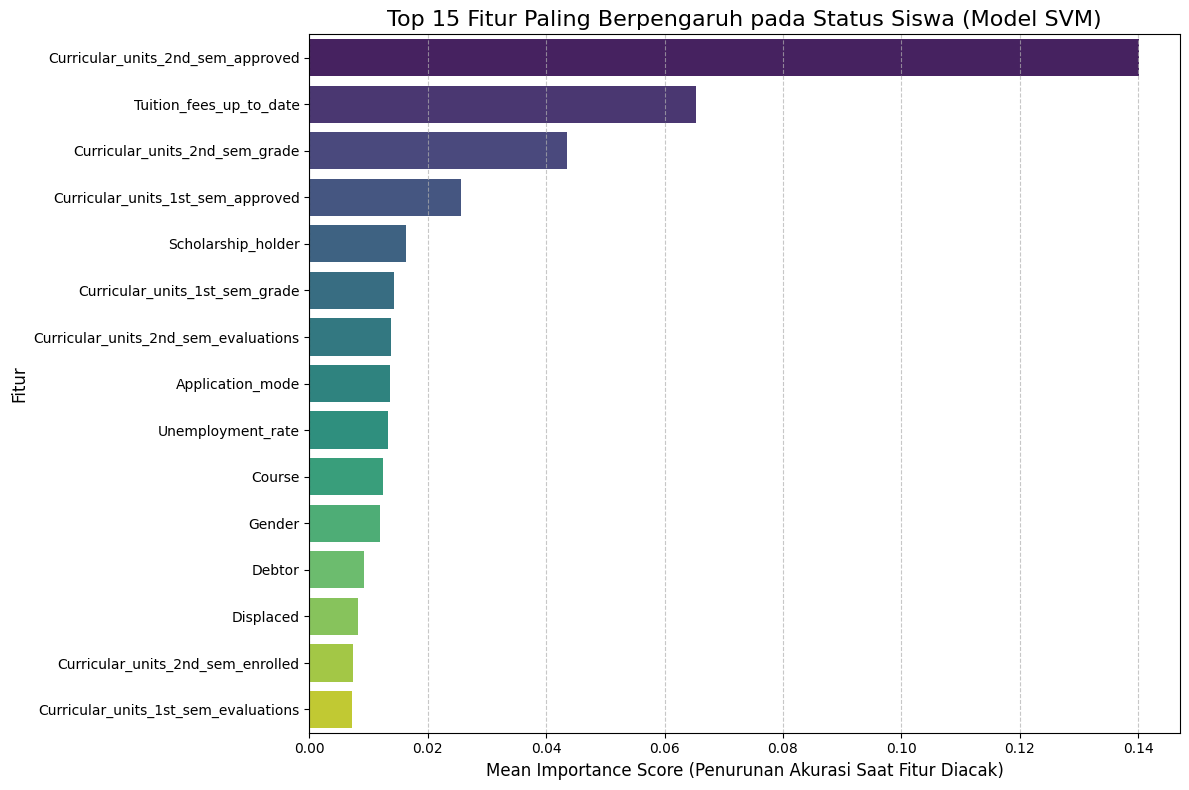


----------------------------------------------------------------------------------
Catatan:
Fitur dengan 'Importance_Mean' yang lebih tinggi menunjukkan bahwa fitur tersebut
sangat berpengaruh pada prediksi model SVM. Saat fitur tersebut diacak,
akurasi model turun secara signifikan.
Pilih fitur-fitur teratas dari daftar ini untuk input di aplikasi prediksimu.


In [16]:
print("\n--- Analisis Fitur Paling Berpengaruh dengan Permutation Importance (Model SVM) ---")

best_model = models['SVM']
feature_names = X_encoded.columns
results = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

feature_importance_perm = pd.DataFrame({
    'Feature': feature_names,
    'Importance_Mean': results.importances_mean,
    'Importance_Std': results.importances_std
})

# Urutkan fitur berdasarkan nilai rata-rata importance dari yang terbesar ke terkecil
# Fitur dengan 'Importance_Mean' tertinggi adalah yang paling berpengaruh
feature_importance_perm = feature_importance_perm.sort_values(by='Importance_Mean', ascending=False)

# Tampilkan hasil dalam bentuk tabel
print("\nTop Fitur Berdasarkan Permutation Importance (Model SVM):")
print(feature_importance_perm)

# --- Visualisasi Hasil (Opsional, untuk melihat top N fitur) ---
plt.figure(figsize=(12, 8))
# Kita bisa menampilkan top 10 atau 15 fitur yang paling penting
sns.barplot(x='Importance_Mean', y='Feature', data=feature_importance_perm.head(15), palette='viridis')
plt.title('Top 15 Fitur Paling Berpengaruh pada Status Siswa (Model SVM)', fontsize=16)
plt.xlabel('Mean Importance Score (Penurunan Akurasi Saat Fitur Diacak)', fontsize=12)
plt.ylabel('Fitur', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n----------------------------------------------------------------------------------")
print("Catatan:")
print("Fitur dengan 'Importance_Mean' yang lebih tinggi menunjukkan bahwa fitur tersebut")
print("sangat berpengaruh pada prediksi model SVM. Saat fitur tersebut diacak,")
print("akurasi model turun secara signifikan.")
print("Pilih fitur-fitur teratas dari daftar ini untuk input di aplikasi prediksimu.")

# Save Model

In [17]:
joblib.dump(best, 'model.joblib')

['model.joblib']